In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('EllipticppDataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

EllipticppDataset/AddrTx_edgelist.csv
EllipticppDataset/txs_edgelist.csv
EllipticppDataset/txs_features.csv
EllipticppDataset/AddrAddr_edgelist.csv
EllipticppDataset/TxAddr_edgelist.csv
EllipticppDataset/wallets_features_classes_combined.csv
EllipticppDataset/txs_classes.csv
EllipticppDataset/wallets_classes.csv
EllipticppDataset/wallets_features.csv


In [80]:
#!pip install torch_geometric
import pandas as pd
import os
import random
import numpy as np
import os.path as osp
import torch
import warnings
from torch_geometric.data import Data, HeteroData
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, ChebConv
import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch_geometric.utils as pyg_utils
from torch.nn import Module, Linear
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support, f1_score
from torch_geometric.seed import seed_everything


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

base_path = f"EllipticppDataset"
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    seed_everything(seed)
device = "cpu"

In [81]:
def load_data():
    # Loading transactions
    
    #Reading edges, features and classes from transaction files (as done with the original dataset)
    df_edges_tx = pd.read_csv(osp.join(base_path, "txs_edgelist.csv"))
    df_features_tx = pd.read_csv(osp.join(base_path, "txs_features.csv"), header=None)
    df_classes_tx = pd.read_csv(osp.join(base_path, "txs_classes.csv"))
    
    #Columns naming based on index
    colNames1_tx = {'0': 'txId', 1: "Time step"}
    colNames2_tx = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(94)}
    colNames3_tx = {str(ii+96): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

    colNames_tx = dict(colNames1_tx, **colNames2_tx, **colNames3_tx)
    colNames_tx = {int(jj): item_kk for jj, item_kk in colNames_tx.items()}
    
    # Rename feature columns
    df_features_tx = df_features_tx.rename(columns=colNames_tx)

    # Map unknown class to '3'
    df_classes_tx.loc[df_classes_tx['class'] == 'unknown', 'class'] = '3'
    
    # Merge classes and features in one Dataframe
    df_class_feature_tx = pd.merge(df_classes_tx, df_features_tx)

    # Exclude records with unknown class transaction
    df_class_feature_tx = df_class_feature_tx[df_class_feature_tx['class'] != 3]

    # Build Dataframe with head and tail of transactions (edges)
    known_txs = df_class_feature_tx["txId"].values
    df_edges_tx = df_edges_tx[(df_edges_tx["txId1"].isin(known_txs)) & (df_edges_tx["txId2"].isin(known_txs))]

    # Build indices for features and edge types
    features_idx_tx = {name: idx for idx, name in enumerate(sorted(df_class_feature_tx["txId"].unique()))}
    class_idx_tx = {name: idx for idx, name in enumerate(sorted(df_class_feature_tx["class"].unique()))}
    
    # Apply index encoding to features
    df_class_feature_tx["txId"] = df_class_feature_tx["txId"].apply(lambda name: features_idx_tx[name])
    df_class_feature_tx["class"] = df_class_feature_tx["class"].apply(lambda name: class_idx_tx[name])
    
    # Apply index encoding to edges
    df_edges_tx["txId1"] = df_edges_tx["txId1"].apply(lambda name: features_idx_tx[name])
    df_edges_tx["txId2"] = df_edges_tx["txId2"].apply(lambda name: features_idx_tx[name])
    
    
    
    # Loading wallets
    
    # From file
    df_edges_wallet = pd.read_csv(osp.join(base_path, "AddrAddr_edgelist.csv"))
    df_class_feature_wallet = pd.read_csv(osp.join(base_path, "wallets_features_classes_combined.csv"))
    
    # Exclude records with unknown class transaction
    print(df_class_feature_wallet.shape)
    df_class_feature_wallet = df_class_feature_wallet[df_class_feature_wallet["class"] != 3]
    print(df_class_feature_wallet.shape)
    
    # Build Dataframe with head and tail of AddrToAddr (edges)
    known_wallets = df_class_feature_wallet["address"].values
    df_edges_wallet = df_edges_wallet[(df_edges_wallet["input_address"].isin(known_wallets)) & (df_edges_wallet["output_address"].isin(known_wallets))]
    
    # Building indices for features and edge types
    features_idx_wallet = {name: idx for idx, name in enumerate(sorted(df_class_feature_wallet["address"].unique()))}
    class_idx_wallet = {name: idx for idx, name in enumerate(sorted(df_class_feature_wallet["class"].unique()))}
    
    # Apply index encoding to features
    df_class_feature_wallet["address"] = df_class_feature_wallet["address"].apply(lambda name: features_idx_wallet[name])
    df_class_feature_wallet["class"] = df_class_feature_wallet["class"].apply(lambda name: class_idx_wallet[name])
    
    # Apply index encoding to edges
    df_edges_wallet["input_address"] = df_edges_wallet["input_address"].apply(lambda name: features_idx_wallet[name])
    df_edges_wallet["output_address"] = df_edges_wallet["output_address"].apply(lambda name: features_idx_wallet[name])
    
    
    
    # Loading AddrTx and TxAddr
    
    # From file
    df_edges_wallet_tx = pd.read_csv(osp.join(base_path, "AddrTx_edgelist.csv"))
    df_edges_tx_wallet = pd.read_csv(osp.join(base_path, "TxAddr_edgelist.csv"))
    
    # Build Dataframe with head and tail of AddrTx (edges)
    df_edges_wallet_tx = df_edges_wallet_tx[(df_edges_wallet_tx["input_address"].isin(known_wallets)) & df_edges_wallet_tx["txId"].isin(known_txs)]
    df_edges_tx_wallet = df_edges_tx_wallet[(df_edges_tx_wallet["txId"].isin(known_txs)) & df_edges_tx_wallet["output_address"].isin(known_wallets)]

    # Apply index encoding to edges
    df_edges_wallet_tx["input_address"] = df_edges_wallet_tx["input_address"].apply(lambda name: features_idx_wallet[name])
    df_edges_wallet_tx["txId"] = df_edges_wallet_tx["txId"].apply(lambda name: features_idx_tx[name])
    df_edges_tx_wallet["txId"] = df_edges_tx_wallet["txId"].apply(lambda name: features_idx_tx[name])
    df_edges_tx_wallet["output_address"] = df_edges_tx_wallet["output_address"].apply(lambda name: features_idx_wallet[name])
    
    return df_class_feature_tx, df_edges_tx, df_class_feature_wallet, df_edges_wallet, df_edges_wallet_tx, df_edges_tx_wallet, features_idx_tx, features_idx_wallet

def data_to_pyg(df_class_feature_tx, df_edges_tx, df_class_feature_wallet, df_edges_wallet, df_edges_wallet_tx, df_edges_tx_wallet, features_idx_tx, features_idx_wallet):
    data = HeteroData()
    
    # Defining PyG objects for transactions
    df_class_feature_tx = df_class_feature_tx.fillna(0)
    data['tx'].x = torch.tensor(df_class_feature_tx.iloc[:, 3:].values, dtype=torch.float)
    data['tx'].y = torch.tensor(df_class_feature_tx["class"].values, dtype=torch.long) 
    data['tx','is_related_to','tx'].edge_index = torch.tensor([df_edges_tx["txId1"].values,
                            df_edges_tx["txId2"].values], dtype=torch.int64)
    #data['tx'] = random_node_split(num_val=0.15, num_test=0.2)(data['tx'])
    # Defining PyG objects for wallets
    data['wallet'].x = torch.tensor(df_class_feature_wallet.iloc[:, 3:].values, dtype=torch.float)
    data['wallet'].y = torch.tensor(df_class_feature_wallet["class"].values, dtype=torch.long) 
    data['wallet','interacts_with','wallet'].edge_index = torch.tensor([df_edges_wallet["input_address"].values,
                            df_edges_wallet["output_address"].values], dtype=torch.int64)
    #data['wallet'] = random_node_split(num_val=0.15, num_test=0.2)(data['wallet'])
    # Defining PyG objects for cross-edges
    data['wallet','performs','tx'].edge_index = torch.tensor([df_edges_wallet_tx["input_address"].values,
                                         df_edges_wallet_tx["txId"].values], dtype=torch.int64) 
    
    data['tx', 'flows_into', 'wallet'].edge_index = torch.tensor([df_edges_tx_wallet["txId"].values,
                                         df_edges_tx_wallet["output_address"].values], dtype=torch.int64)
    
    
    return RandomNodeSplit(num_val=0.15, num_test=0.2)(data)


data = data_to_pyg(*load_data())
    

/var/folders/n7/t9yxgh991sq88r4lqvdxf2hc0000gn/T/ipykernel_30243/2217015762.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183) have mixed types. Specify dtype option on import or set low_memory=False.
  df_features_tx = pd.read_csv(osp.join(base_path, "txs_features.csv"), header=None)


(1268260, 58)
(367472, 58)


In [82]:
print(data.metadata())
print(data.edge_index_dict)

(['tx', 'wallet'], [('tx', 'is_related_to', 'tx'), ('wallet', 'interacts_with', 'wallet'), ('wallet', 'performs', 'tx'), ('tx', 'flows_into', 'wallet')])
{('tx', 'is_related_to', 'tx'): tensor([[31238, 31032, 30972,  ..., 22157, 21966, 22063],
        [31533, 31469, 31478,  ..., 21966,  3379, 22011]]), ('wallet', 'interacts_with', 'wallet'): tensor([[ 38353, 155547, 169711,  ..., 260097, 260097, 260097],
        [120622, 120622, 120622,  ..., 260097, 260097, 260097]]), ('wallet', 'performs', 'tx'): tensor([[ 83669,  55941, 152588,  ..., 125390,  26995,   1593],
        [ 30799,  30799,  30799,  ...,  21978,  21980,  21980]]), ('tx', 'flows_into', 'wallet'): tensor([[ 30799,  30800,  30800,  ...,  21978,  21980,  21980],
        [  4186,  55834, 250816,  ..., 127426, 189067,  61787]])}


In [83]:
import torch_geometric.transforms as T
from torch_geometric.nn import ChebConv, GCNConv, SAGEConv, HGTConv, Linear, HANConv, HeteroConv

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()
        self.message = "HGT"
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)
        
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(), num_heads)
            self.convs.append(conv)
            
        self.lin_tx = Linear(hidden_channels, out_channels)    
        self.lin_wallet = Linear(hidden_channels, out_channels)

        
    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type]=self.lin_dict[node_type](x).relu_()
            
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            
        return self.lin_tx(x_dict['tx']), self.lin_wallet(x_dict['wallet'])

class HAN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()
        self.message = "HAN"
        self.lin_dict= torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)
            
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HANConv(hidden_channels, hidden_channels, data.metadata(), dropout=0.2, heads=num_heads)
            self.convs.append(conv)
            
        self.lin_tx = Linear(hidden_channels, out_channels)
        self.lin_wallet = Linear(hidden_channels, out_channels)
        
    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()
        
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
        
        return self.lin_tx(x_dict['tx']), self.lin_wallet(x_dict['wallet'])
                            
    


In [84]:
def train(model, optimizer, epochs):
    print('=' * 65)
    print(f"Training and validation stats for the {model.message} model")
    print('=' * 65)
    print()
    set_seed(SEED)
    model.train()
    tx_mask = data['tx'].train_mask
    wallet_mask = data['wallet'].train_mask 
    tx_mask_val =  data['tx'].val_mask
    wallet_mask_val = data['wallet'].val_mask

    best_val_tx_loss = float('inf')
    best_val_wallet_loss = float('inf')
    patience = 150
    epochs_since_best = 0

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out_tx, out_wallet = model(data.x_dict, data.edge_index_dict)
        tx_loss = F.cross_entropy(out_tx[tx_mask], data['tx'].y[tx_mask])
        tx_acc = accuracy(out_tx[tx_mask].argmax(dim=1), data['tx'].y[tx_mask])
        wallet_loss = F.cross_entropy(out_wallet[wallet_mask], data['wallet'].y[wallet_mask])
        wallet_acc = accuracy(out_wallet[wallet_mask].argmax(dim=1), data['wallet'].y[wallet_mask])
        
        loss = tx_loss + wallet_loss
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
          val_tx_loss = F.cross_entropy(out_tx[tx_mask_val], data['tx'].y[tx_mask_val])
          val_tx_acc = accuracy(out_tx[tx_mask_val].argmax(dim=1), data['tx'].y[tx_mask_val])
          val_wallet_loss = F.cross_entropy(out_wallet[wallet_mask_val], data['wallet'].y[wallet_mask_val])
          val_wallet_acc = accuracy(out_wallet[wallet_mask_val].argmax(dim=1), data['wallet'].y[wallet_mask_val])  
        # Print training statistics
        if (epoch % 50 == 0 or epoch == epochs) and epoch != 0:
            print(f'Epoch {epoch}/{epochs}, Val Tx Loss:{val_tx_loss.item()}, Val Wallet Loss:{val_wallet_loss.item()}, Val Tx Accuracy:{val_tx_acc}, Val Wallet Accuracy:{val_wallet_acc}')
        
        # Check if validation loss has improved
        if val_tx_loss < best_val_tx_loss or val_wallet_loss < best_val_wallet_loss:
            best_val_tx_loss = val_tx_loss
            best_val_wallet_loss = val_wallet_loss
            epochs_since_best = 0
        else:
            epochs_since_best += 1

        # Check if early stopping criteria is met
        if epochs_since_best >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    return model

def accuracy(pred_y, y):
    """Calculate accuracy"""
    return ((pred_y == y).sum() / len(y)).item()

def compute_metrics(model):
    print('=' * 65)
    print(f"Test stats and F1 for the {model.message} model")
    print('=' * 65)
    tx_test_mask = data['tx'].test_mask
    wallet_test_mask = data['wallet'].test_mask
    with torch.no_grad():
        torch.manual_seed(SEED)
        out_tx, out_wallet = model(data.x_dict, data.edge_index_dict)
        prec_tx_ill,rec_tx_ill,f1_tx_ill,_ = precision_recall_fscore_support(data['tx'].y[tx_test_mask], 
                                                                             out_tx[tx_test_mask].argmax(dim=1), 
                                                                            average='binary') #pos_label=0
        prec_wallet_ill,rec_wallet_ill,f1_wallet_ill,_ = precision_recall_fscore_support(data['wallet'].y[wallet_test_mask], 
                                                                                         out_wallet[wallet_test_mask].argmax(dim=1), 
                                                                                        average='binary') #pos_label=0
        f1_micro_tx = f1_score(data['tx'].y[tx_test_mask], out_tx[tx_test_mask].argmax(dim=1), average='micro')
        f1_micro_wallet = f1_score(data['wallet'].y[wallet_test_mask], out_wallet[wallet_test_mask].argmax(dim=1), average='micro')
        print(f'Micro F1 Avg on Txs: {f1_micro_tx}, Micro F1 Avg on Wallets: {f1_micro_wallet}')
        print(f'Precision on Txs: {prec_tx_ill}, Precision on Wallets: {prec_wallet_ill}')
        print(f'Recall on Txs: {rec_tx_ill}, Recall on Wallets: {rec_wallet_ill}')
        print(f'F1 on Txs: {f1_tx_ill}, F1 on Wallets: {f1_wallet_ill}')
        m_tx = {'model': model.message, 'Precision': np.round(prec_tx_ill,3), 'Recall': np.round(rec_tx_ill,3), 
                'F1': np.round(f1_tx_ill,3), 'F1 Micro AVG':np.round(f1_micro_tx,3)}
        m_wallet = {'model': model.message, 'Precision': np.round(prec_wallet_ill,3), 'Recall': np.round(rec_wallet_ill,3), 
                'F1': np.round(f1_wallet_ill,3), 'F1 Micro AVG':np.round(f1_micro_wallet,3)}
    return m_tx, m_wallet


In [85]:
class HeteroSAGE(torch.nn.Module):
    def __init__(self, hidden_channels = 64, out_channels = 2, num_layers = 2):
        super().__init__()
        self.message = "Heterogeneous SAGE"
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('tx','is_related_to','tx'): SAGEConv(-1, hidden_channels),
                ('wallet','interacts_with','wallet'): SAGEConv(-1, hidden_channels),
                ('wallet','performs','tx'): SAGEConv(-1, hidden_channels),
                ('tx', 'flows_into', 'wallet'): SAGEConv(-1, hidden_channels)
            }, aggr='sum')
            self.convs.append(conv)
        self.lin_tx = Linear(hidden_channels, out_channels)
        self.lin_wallet = Linear(hidden_channels, out_channels)
    
    def forward(self, x_dict, edge_index_dict):
        
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        return self.lin_tx(x_dict['tx']), self.lin_wallet(x_dict['wallet'])
        
        

In [86]:
class HeteroGAT(torch.nn.Module):
    def __init__(self, hidden_channels = 64, out_channels = 2, num_layers = 2):
        super().__init__()
        self.message = "Heterogeneous GAT"
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('tx','is_related_to','tx'): GATConv((-1, -1), hidden_channels, add_self_loops = False),
                ('wallet','interacts_with','wallet'): GATConv((-1, -1), hidden_channels, add_self_loops = False),
                ('wallet','performs','tx'): GATConv((-1, -1), hidden_channels, add_self_loops = False),
                ('tx', 'flows_into', 'wallet'): GATConv((-1, -1), hidden_channels, add_self_loops = False)
            }, aggr='sum')
            self.convs.append(conv)
        self.lin_tx = Linear(hidden_channels, out_channels)
        self.lin_wallet = Linear(hidden_channels, out_channels)
    
    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        return self.lin_tx(x_dict['tx']), self.lin_wallet(x_dict['wallet'])

In [87]:
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_channels = 64, out_channels = 2, num_layers = 2):
        super().__init__()
        self.message = "Heterogeneous GCN"
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('tx','is_related_to','tx'): GCNConv(-1, hidden_channels, add_self_loops = False),
                ('wallet','interacts_with','wallet'): GCNConv(-1, hidden_channels, add_self_loops = False),
                ('wallet','performs','tx'): GCNConv(-1, hidden_channels, add_self_loops = False),
                ('tx', 'flows_into', 'wallet'): GCNConv(-1, hidden_channels, add_self_loops = False)
            }, aggr='sum')
            self.convs.append(conv)
        self.lin_tx = Linear(hidden_channels, out_channels)
        self.lin_wallet = Linear(hidden_channels, out_channels)
    
    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        return self.lin_tx(x_dict['tx']), self.lin_wallet(x_dict['wallet'])

In [88]:
class HeteroCheb(torch.nn.Module):
    def __init__(self, hidden_channels = 64, out_channels = 2, num_layers = 2):
        super().__init__()
        self.message = "Heterogeneous GCN"
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('tx','is_related_to','tx'): ChebConv(-1, hidden_channels, K=3),
                ('wallet','interacts_with','wallet'): ChebConv(-1, hidden_channels, K=3),
                ('wallet','performs','tx'): ChebConv(-1, hidden_channels, K=3),
                ('tx', 'flows_into', 'wallet'): ChebConv(-1, hidden_channels, K=3)
            }, aggr='sum')
            self.convs.append(conv)
        self.lin_tx = Linear(hidden_channels, out_channels)
        self.lin_wallet = Linear(hidden_channels, out_channels)
    
    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        return self.lin_tx(x_dict['tx']), self.lin_wallet(x_dict['wallet'])

In [89]:
models = []
HGTmodel = HGT(hidden_channels = 64, out_channels = 2, num_heads = 2, num_layers = 2)
HANmodel = HAN(hidden_channels = 64, out_channels = 2, num_heads = 2, num_layers = 2)
SAGEModel = HeteroSAGE(hidden_channels = 64)
GATModel = HeteroGAT(hidden_channels = 64)
#GCNModel = HeteroGCN(hidden_channels = 64)
#ChebModel = HeteroCheb(hidden_channels = 64)
#models.append(ChebModel)
#models.append(GCNModel)
models.append(GATModel)
models.append(SAGEModel)
models.append(HGTmodel)
models.append(HANmodel)
num_epochs=1000

compare_models_tx = pd.DataFrame(columns=['model','Precision','Recall', 'F1', 'F1 Micro AVG'])
compare_models_wallets = pd.DataFrame(columns=['model','Precision','Recall', 'F1', 'F1 Micro AVG'])

for model in models:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model = train(model, optimizer, num_epochs)
    metrics_tx, metrics_wallet = compute_metrics(model)
    metrics_df_tx = pd.DataFrame(metrics_tx, index=[0])  # Convert the dictionary to a DataFrame
    metrics_df_wallet = pd.DataFrame(metrics_wallet, index=[0])  # Convert the dictionary to a DataFrame
    compare_models_tx = pd.concat([compare_models_tx, metrics_df_tx], ignore_index=True)
    compare_models_wallets = pd.concat([compare_models_wallets, metrics_df_wallet], ignore_index=True)
    print('-'*50+"\nResults so far:")
    print('-'*10+"\nTransactions:")
    print(compare_models_tx)
    print('-'*10+"\nWallets:")
    print(compare_models_wallets)
    print('-'*50)


Training and validation stats for the Heterogeneous GAT model

Epoch 50/1000, Val Tx Loss:274.0526123046875, Val Wallet Loss:147.8756103515625, Val Tx Accuracy:0.8952757120132446, Val Wallet Accuracy:0.9108144044876099
Epoch 100/1000, Val Tx Loss:626.4675903320312, Val Wallet Loss:141.5641632080078, Val Tx Accuracy:0.8989322781562805, Val Wallet Accuracy:0.9233141541481018
Epoch 150/1000, Val Tx Loss:142.29052734375, Val Wallet Loss:92.30825805664062, Val Tx Accuracy:0.8984934687614441, Val Wallet Accuracy:0.8515810966491699
Epoch 200/1000, Val Tx Loss:98.40401458740234, Val Wallet Loss:179.7908935546875, Val Tx Accuracy:0.8212666511535645, Val Wallet Accuracy:0.9232597351074219
Epoch 250/1000, Val Tx Loss:182.18243408203125, Val Wallet Loss:38.53207015991211, Val Tx Accuracy:0.8092730641365051, Val Wallet Accuracy:0.9027230739593506
Epoch 300/1000, Val Tx Loss:86.25153350830078, Val Wallet Loss:120.25535583496094, Val Tx Accuracy:0.8932279944419861, Val Wallet Accuracy:0.9180711507797

In [90]:
def aggregate_plot(df, fig_name):

    labels = df['model'].to_numpy()

    precision = df['Precision'].to_numpy()
    recall = df['Recall'].to_numpy()
    f1 = df['F1'].to_numpy()
    maf1 = df['F1 Micro AVG'].to_numpy()

    x = np.arange(len(labels))  # the label locations
    width = 0.55  # the width of the bars
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.bar(x, f1, width, label='F1 Score',color='#f2b37b')
    ax.bar(x , maf1, width, label='M.A. F1 Score',color='#7b8bf2',bottom=f1)
    ax.bar(x, precision, width, label='Precision',color='#83f27b',bottom=maf1 + f1)
    ax.bar(x, recall, width, label='Recall',color='#f27b83',bottom=maf1 + f1 + precision)

    ax.set_ylabel('value 0-1')
    ax.set_title('Final metrics by classifier')
    ax.set_xticks(np.arange(0,len(labels),1))
    ax.set_yticks(np.arange(0,4,0.1))
    ax.set_xticklabels(labels=labels)
    ax.legend()

    plt.xticks(rotation=90)
    plt.grid(True)
    fig.tight_layout()
    plt.show()
    fig.savefig(fig_name)


==================== RESULTS =====================

Transactions==============================
                model  Precision  Recall     F1  F1 Micro AVG
0   Heterogeneous GAT      0.900   0.899  0.900         0.819
1  Heterogeneous SAGE      0.914   0.995  0.953         0.912
2                 HGT      0.900   1.000  0.947         0.900
3                 HAN      0.900   0.999  0.947         0.900


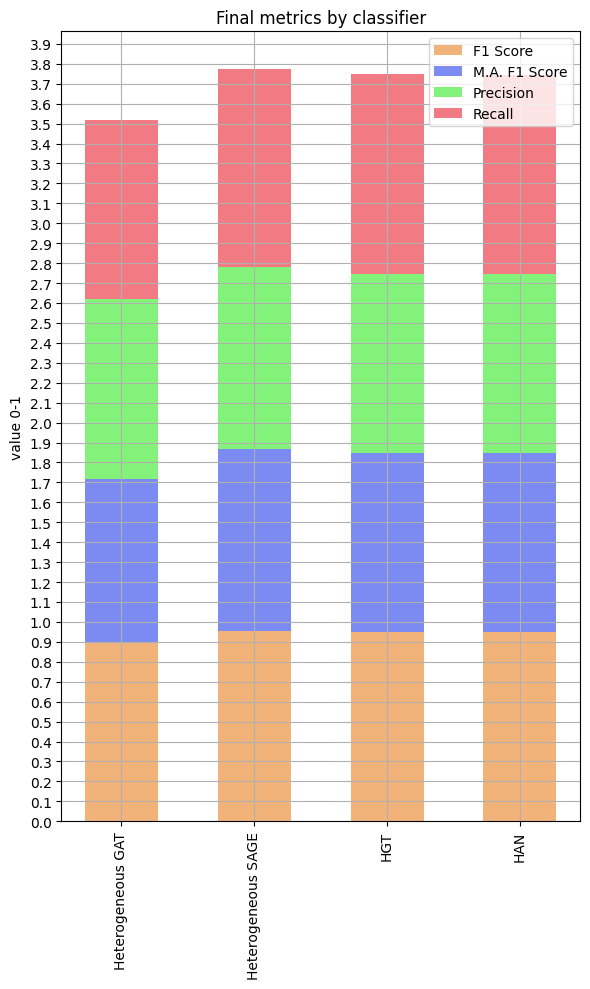

Wallets==============================
                model  Precision  Recall     F1  F1 Micro AVG
0   Heterogeneous GAT      0.922   1.000  0.959         0.921
1  Heterogeneous SAGE      0.948   0.897  0.922         0.860
2                 HGT      0.975   0.820  0.891         0.815
3                 HAN      0.922   0.999  0.959         0.921


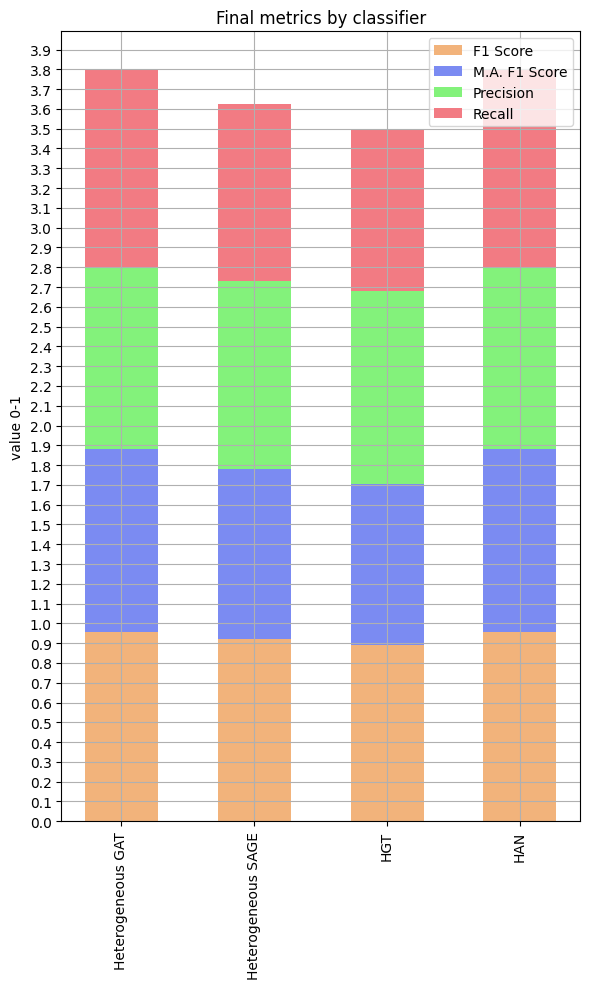

In [91]:
import matplotlib.pyplot as plt
print('='*50)
print('='*20 + " RESULTS "+ '='*21)
print('='*50)
print()

print('='*30+"\nTransactions"+'='*30)
print(compare_models_tx)
aggregate_plot(compare_models_tx, "results_tx.png")

print('='*30+"\nWallets"+'='*30)
print(compare_models_wallets)
aggregate_plot(compare_models_wallets, "results_wallets.png")
